# Comparison of 2013 Raw vs. Quality Controlled_07.15.19

In [1]:
# libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os,sys
from rfpimp import oob_dropcol_importances, cv_importances, oob_importances, dropcol_importances, importances, plot_importances
from matplotlib.ticker import FormatStrFormatter
from functools import reduce

In [2]:
## define a function for calculating importances by MSE
def mse(model, X, y, sample_weights=None):
    y_pred = model.predict(X)
    mse = np.sum((y-y_pred)**2) / np.max(y.shape)
    return mse

In [113]:
# making a function to run through RF and produce plots, takes in new column names to drop

def rf_sonarproject(path,raw,drop_columns):
    '''
    *Runs Random Forest Regressor to predict log NASC values from input csv. 
    *Produces 3 plots. First plot shows relative importance of input variables.
        Second plot shows variable importance across all models (all frequencies and depths).
        Third plot shows observed vs. predicted log NASC Values. 
    *Inputs:
        - path: path of csv file for data
        - raw: True (raw sonar data) or False (quality controlled sonar data)
        - drop_columns: list of str column names to drop when running the RF model (used for testing independent \
        outputs from sonar, MODIS, or other data)
        - Options for 'drop_columns' input var:
            > Only MODIS Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m',\
                        'distance_from_shore_m','Day']
            > Only Sonar Data: drop_columns =['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']
            > Only Non-MODIS or NON-Sonar Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','depth_m',\
                        'distance_from_shore_m']
            > All Non-Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']
        *** Order of elements in drop_columns list does matter for plot naming and image saving ***
    '''
    d = pd.read_csv(path)
    d = d.query('NASC > 0')  # filter out zero-value NASC
    d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
    d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
    d = d.assign(depth_m = d.depth_m.astype(np.float64))
    d = d.query(f'log_nasc < 17.5 & is_raw == {raw}')

    feats = [
        'Lon', 
        'Lat',
        'distance_from_shore_m',
        'depth_m',
        'log_nasc', 
        'wavelength', 
        'depth_bin',
        'Day',
        'is_raw'
    ]
    
    filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
    d = d[filter_col]
    d = d.dropna()
   
    wavelengths = d.wavelength.unique()
    wavelengths.sort()
    depth_bins = d.depth_bin.unique()

    #########################################################################################################
    # Plot 1: Var Importance for each individual model
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

    rf_mse_list = []
    rf_mse_dict = {}
    rf_mse_list2 = []
    imps = []
    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            # check to see if x has has any rows, continue if no data
            if subd.shape == (0,24):
                rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':0}) 
                rf_mse_list2.append(0)
                continue
                
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
            y = subd.log_nasc
            x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            ## do the same for mse
            rf_imp_mse = importances(rf, x_test, y_test, metric=mse)

            title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
            rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
            imps.append(np.abs(rf_imp_mse.Importance.values))

            #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
            rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
            axes[j, i].set_title(title)

            # add model to lst of dfs...concatenate later
            #change title of columns in df from 'importance_x' to 'model...'
            rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_list.append(rfmse_df)

            #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
            rf_mse_list2.append(mse(rf,x_test, y_test))


    plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','is_raw']:
        fig.suptitle(f'Random Forest: MSE Variable Importances - All Data - Raw Data {raw}\n',fontsize=20)
        plt.savefig(f'2013_{raw}_RF-MSE_var_importances.png')
        plt.show()

    #################################################################################################################
    # Plot #2: Var Importance across all models
    ### df rf mse

    # df: sort values descending and ascending values for max avg
    from functools import reduce

    # make row identifier "column" a real column
    for i in rf_mse_list:
        i.reset_index(inplace=True)

    # sort by mean model importance to determine sort order for plots
    #print(df_list[0], (df_list[0]).shape)
    df_rf_mse = reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), rf_mse_list)
    reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), rf_mse_list)

    # get the average relative feature importances for all models

    col_rfmse = df_rf_mse.columns[1:]  # gets just the importances columns, not index or feature name columns
    df_rf_mse.columns
    col_list = list(df_rf_mse)

    def remove_vals(the_list, val):
        return [value for value in the_list if value != val]

    x = remove_vals(col_list, 'index_y')
    y = remove_vals(x, 'index_x')

    feature_labels = df_rf_mse['Feature']
    feature_sum = df_rf_mse.sum(axis=1) / len(feature_labels)  # average of values
    #print(feature_sum)
    feature_sum = feature_sum.sort_values()

    # plot ranking of var importances across all models while using rf
    y_pos = np.arange(len(feature_labels))
    fig = plt.figure(figsize=(30,15))
    plt.barh(y_pos, feature_sum, align='center', alpha=0.5,color='forestgreen')
    plt.yticks(y_pos, feature_labels,fontsize=30)
    plt.xlabel('Relative Feature Importance',fontsize=30)
    plt.title(f'Importance of Feature Variables Across All Models:\n Updated Depth Bins & Combined Years 2012,2013,2015 \n - Raw Data {raw}\n',\
              fontsize=30)
    plt.savefig(f'2013_{raw}_importance_feature_variables_all_models.png')
    plt.show()

    #################################################################################################################
    # Plot 3: Observed vs. Predicted Log NASC
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                           sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            # check to see if x has has any rows, continue if no data
            if subd.shape == (0,24):
                continue
                
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe
            y = subd.log_nasc
            x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            y_test_hat = rf.predict(x_test)
            y_train_hat = rf.predict(x_train)

            axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
            #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
            axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
            axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                               '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))

            # add axis labels on the edge plots
            if wavelength == wavelengths[0]:
                axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
            if depth_bin == depth_bins[-1]:
                axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)

    plt.subplots_adjust(hspace=0.5,wspace=0.2)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','is_raw']:
        fig.suptitle(f'Random Forest: MSE Variable Importances - All Data - Raw Data {raw}\n',fontsize=20)
        plt.savefig(f'2013_{raw}_alldata_RF-MSE_var_importances.png')
        plt.show()
        
    return (rf_mse_list2,rf_mse_dict)


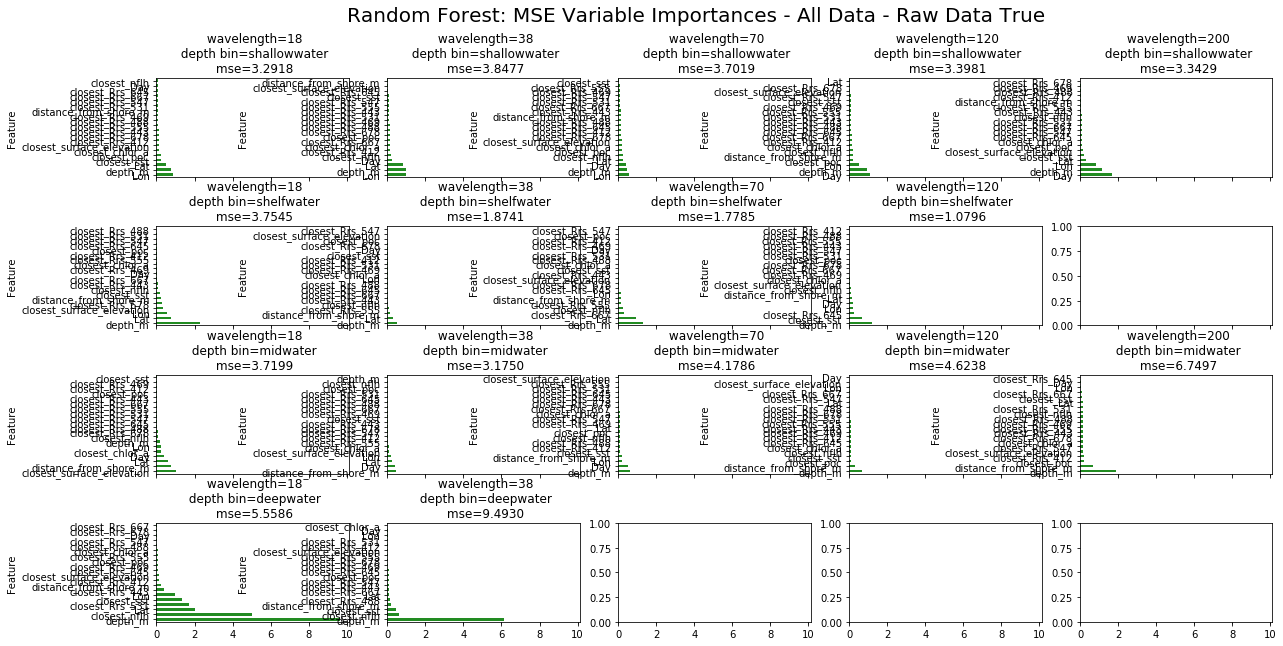

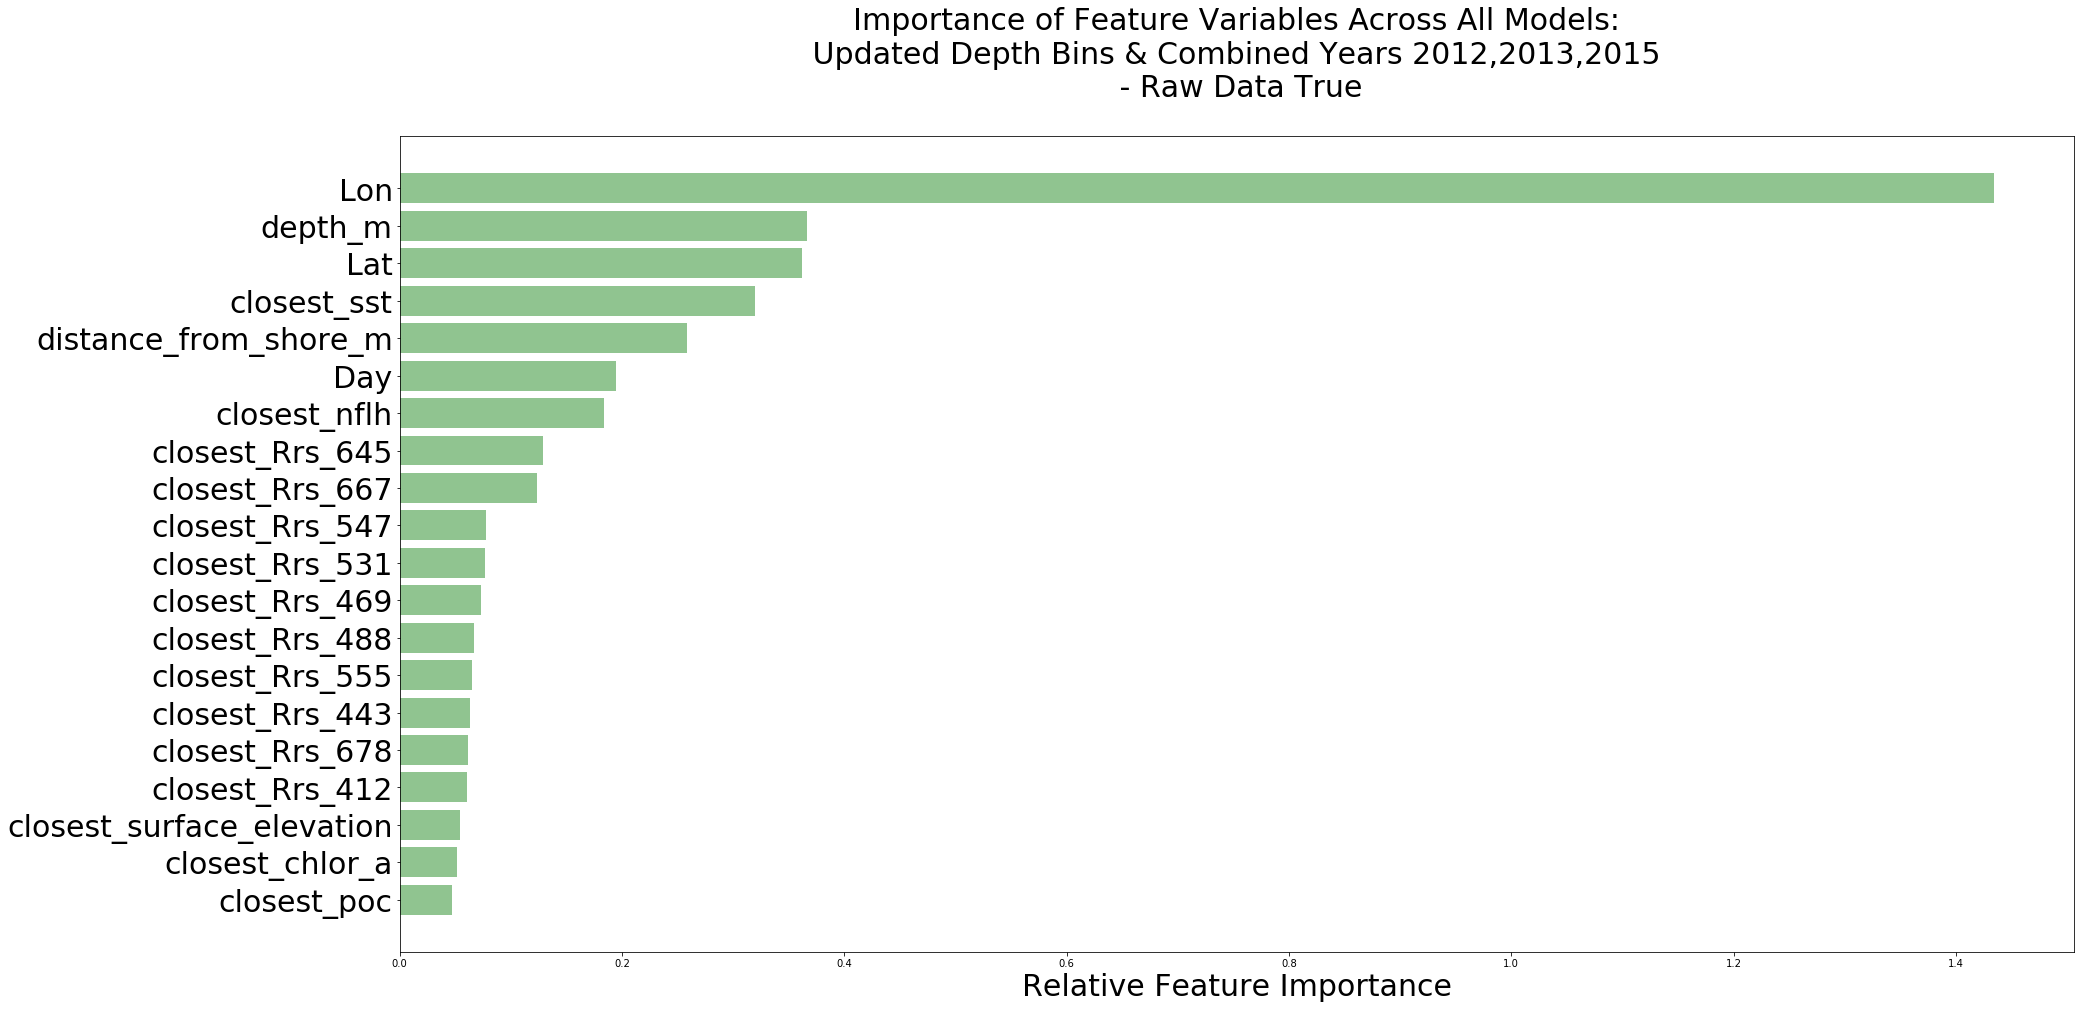

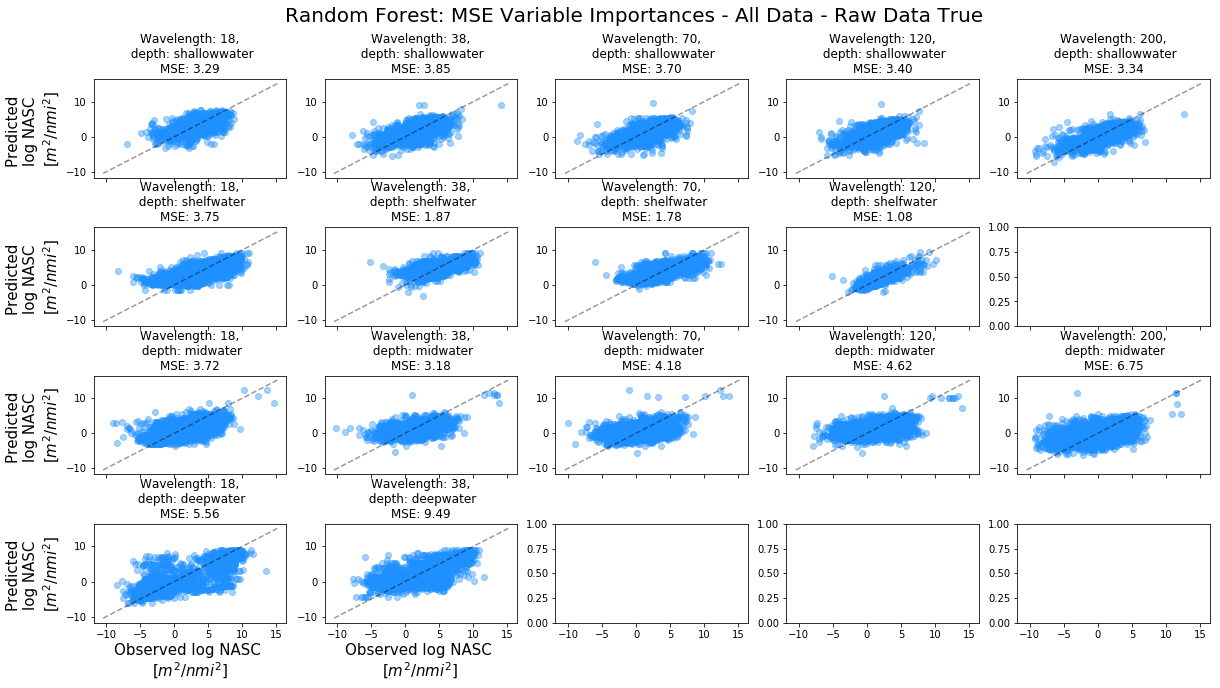

In [114]:
# 2013 Raw Sonar Data

# All Data (MODIS + sonar + depth_m and distance_from_shore_m)

path_2013 = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-07-09_2013_nasc_sonar.csv'
drop_columns = ['log_nasc', 'wavelength', 'depth_bin','is_raw']
mse_raw, dict_raw = rf_sonarproject(path_2013,True, drop_columns)

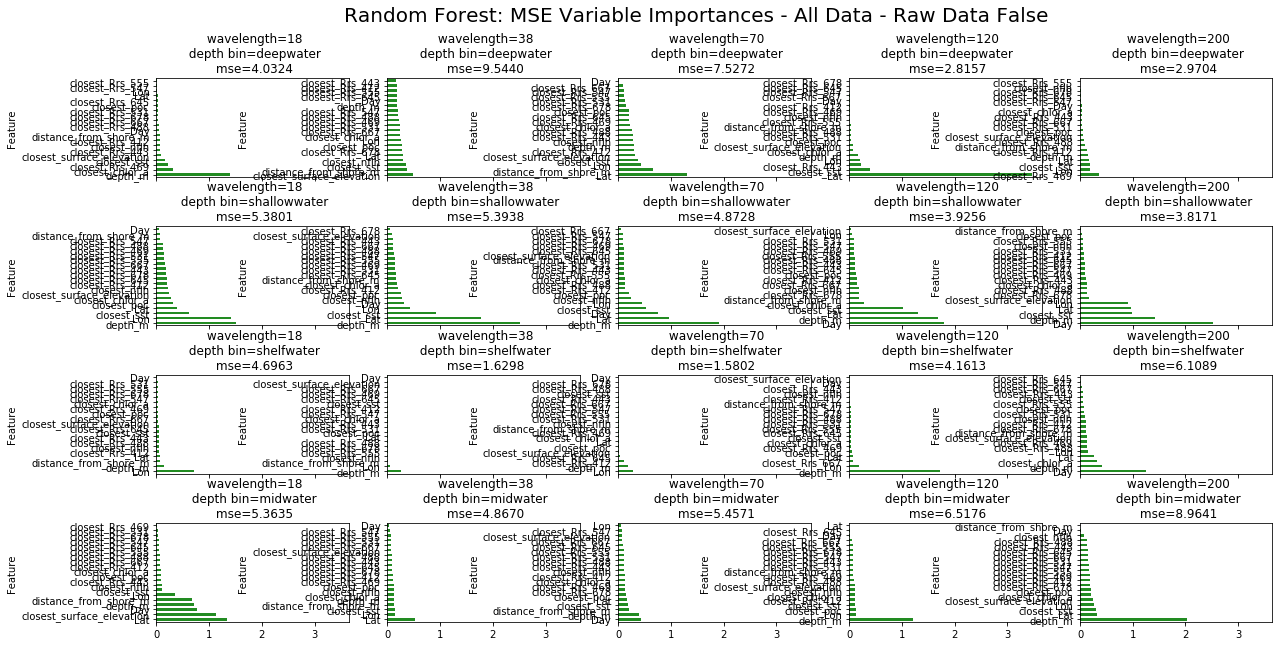

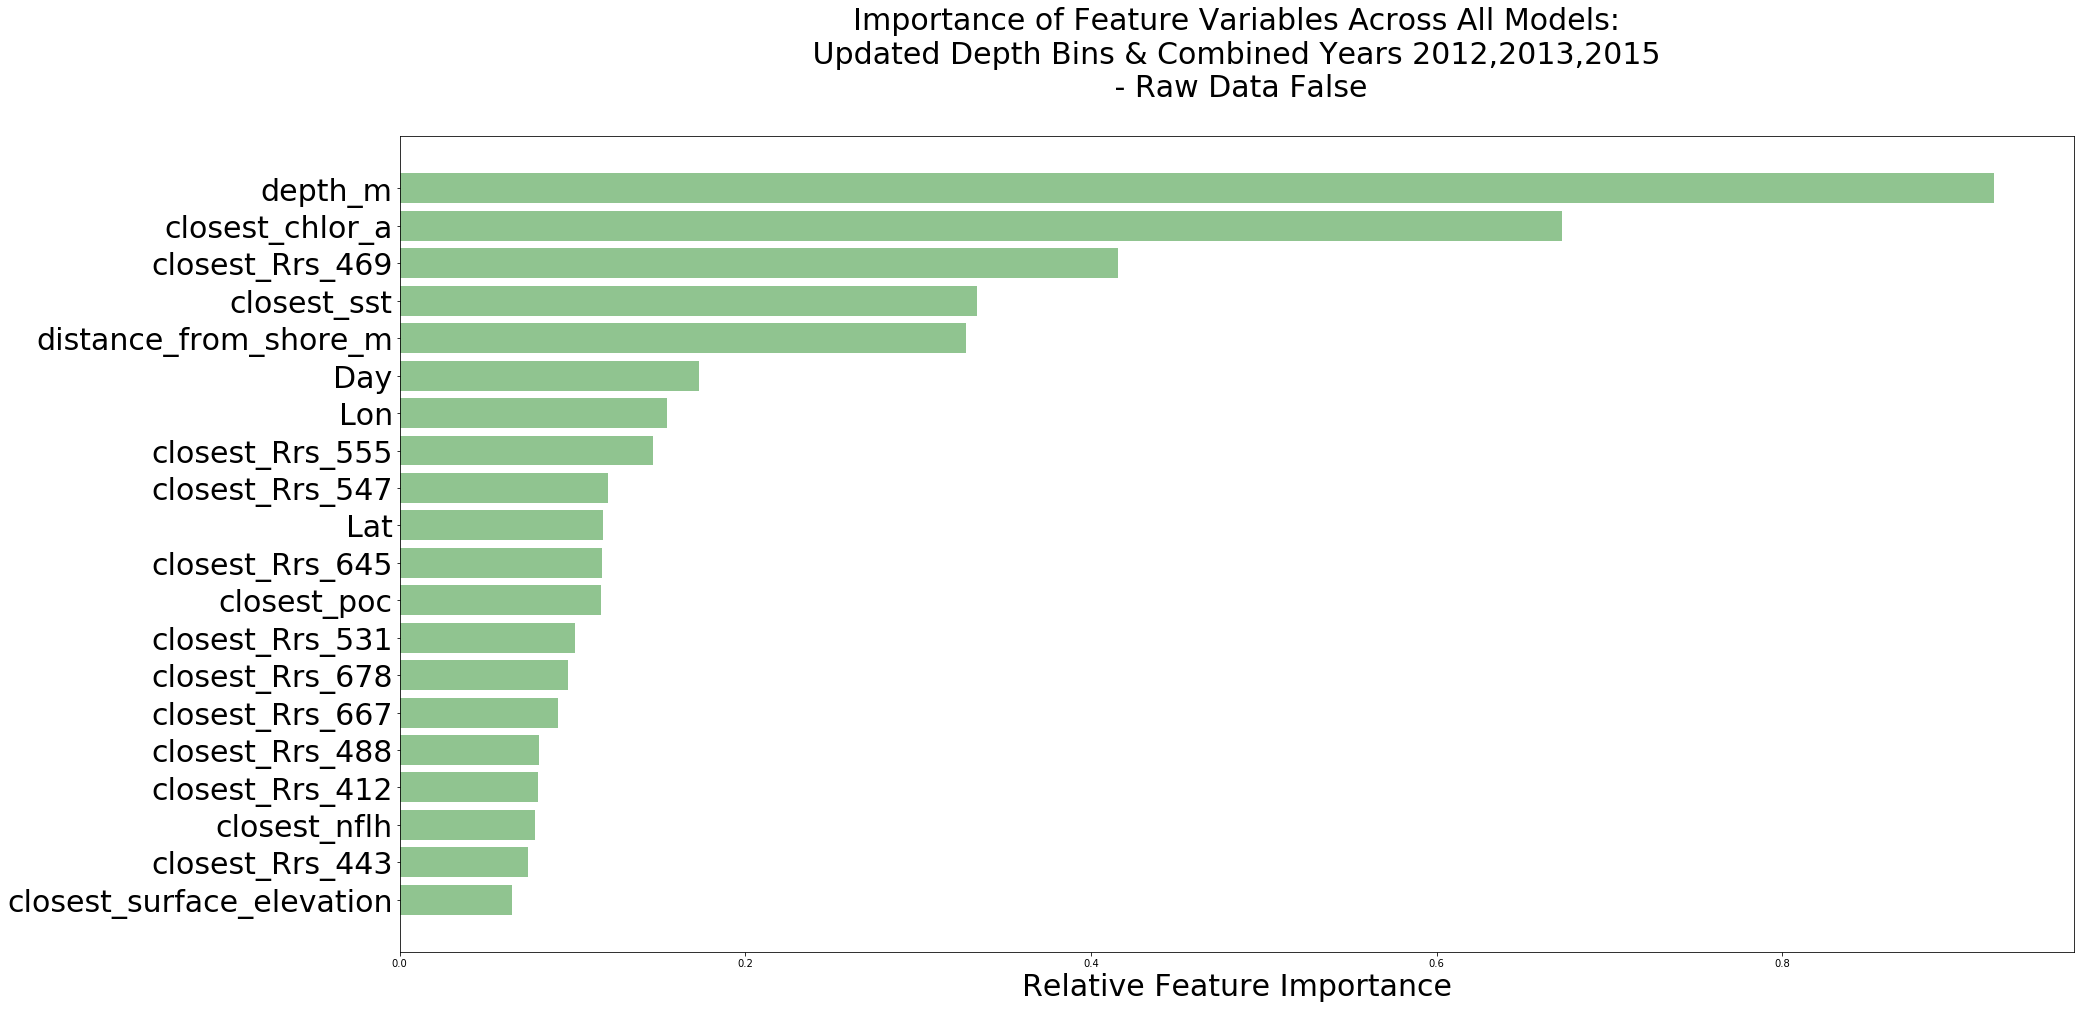

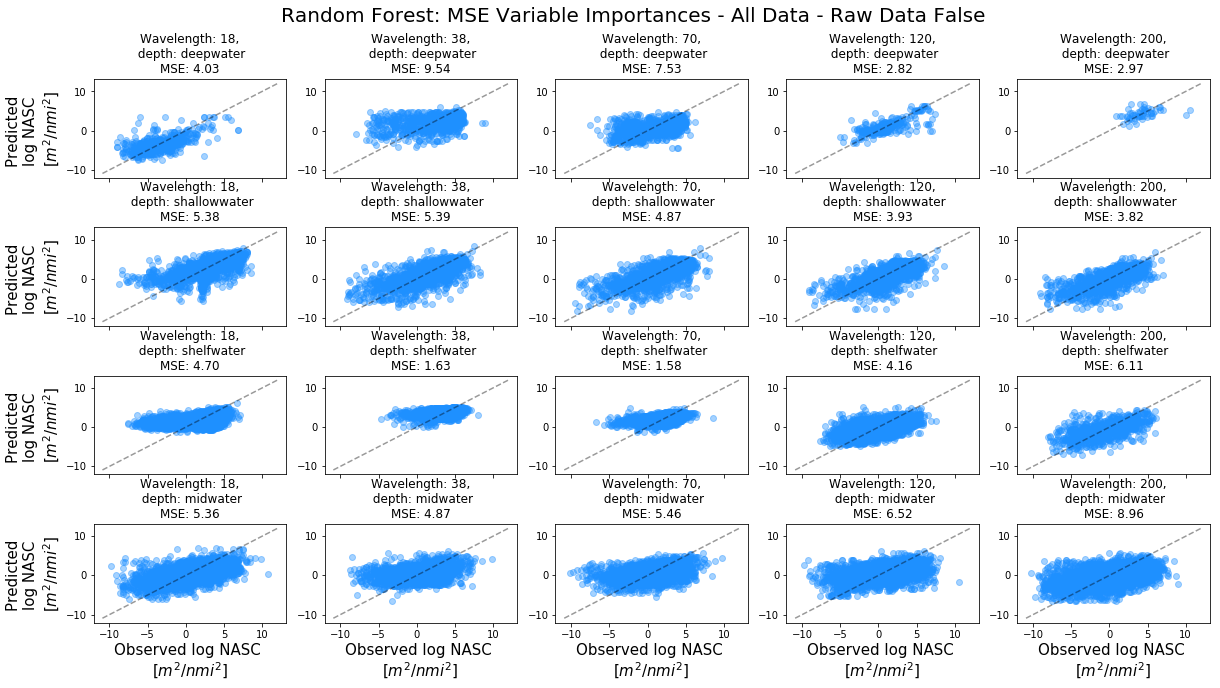

In [115]:
# 2013 Quality Controlled Sonar Data

# All Data (MODIS + sonar + depth_m and distance_from_shore_m)

path_2013 = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-07-09_2013_nasc_sonar.csv'
drop_columns = ['log_nasc', 'wavelength', 'depth_bin','is_raw']
mse_qc, dict_qc = rf_sonarproject(path_2013,False, drop_columns)

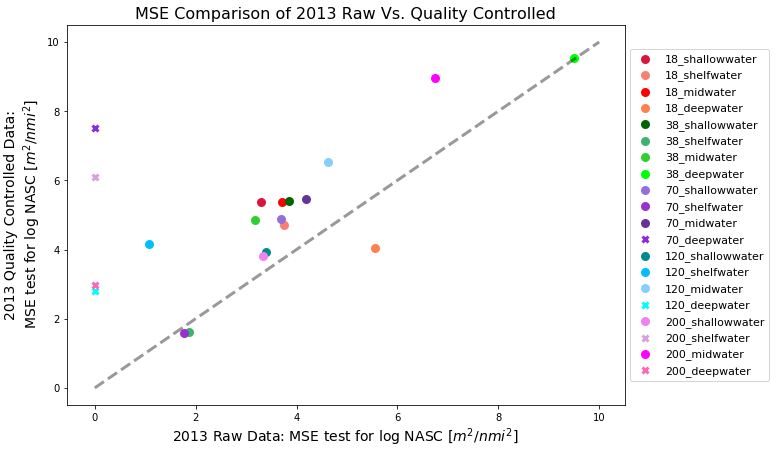

In [150]:
# make plot like nn vs. rf for all models to compare mse scores

# trying to add labels via dict to mse comparison plot

#yrange = np.linspace(min(min(mse_qc),min(mse_qc)), max(max(mse_qc),max(mse_qc), 10))  # for one-to-one line
yrange = np.linspace(min(min(mse_raw),min(mse_raw)), max(max(mse_raw),max(mse_raw), 10))  # for one-to-one line

# need 20 different colors to cycle through for model visualization
colors = ['crimson','salmon','red','coral',
         'darkgreen','mediumseagreen','limegreen','lime',
         'mediumpurple','darkorchid','rebeccapurple','blueviolet',
         'darkcyan','deepskyblue','lightskyblue','aqua',
         'violet','plum','magenta','hotpink']


rf_raw = []
rf_qc = []
labels7 = []
for key, value in dict_raw.items():
    label = key
    rf_raw.append(dict_raw[key])
    rf_qc.append(dict_qc[key])
    labels7.append(label)

###
fig, ax = plt.subplots(figsize=(10, 7))
for i,element in enumerate(rf_raw):
    if rf_raw[i] == 0:
        ax.scatter(rf_raw[i],rf_qc[i],color=colors[i],label=labels7[i],marker='x',linewidth=3)
        continue
    ax.scatter(rf_raw[i],rf_qc[i],color=colors[i],label=labels7[i],linewidth=3)
ax.plot(yrange, yrange, '--',c='k',alpha = 0.4,linewidth = 3)
plt.title('MSE Comparison of 2013 Raw Vs. Quality Controlled', fontsize = 16)
plt.xlabel('2013 Raw Data: MSE test for log NASC [$m^2 /nmi^2$]', fontsize = 14)
plt.ylabel('2013 Quality Controlled Data:\n MSE test for log NASC [$m^2 /nmi^2$]', fontsize = 14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 11)
plt.savefig('MSEcomparison_2013_rawVSqc.png')  # test 8 using random_state=13
plt.show()

# log nasc units: m^2/nmi^2
# NASC (Nautical Area Scattering Coefficient - m2nmi-2)


## Initial Data Exploration

In [72]:
# 2013 File path and file exploration

path_2013 = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-07-09_2013_nasc_sonar.csv'

d = pd.read_csv(path_2013)#, nrows=10000) #had trouble getting permissions to read csv while trying to open in excel
print(d.columns)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
#d = d.query('log_nasc < 17.5')
d = d.query('log_nasc < 17.5 & is_raw == False')
#print(d)

#d = np.where(d['is_raw'] == True)
feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day',
    'is_raw'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
#print(d.head())
print(d.shape)
d = d.dropna()
print(type(d))
print(d.shape)


wavelengths = d.wavelength.unique()
wavelengths.sort()
depth_bins = d.depth_bin.unique()

print(wavelengths.shape)
print("wavelengths: ",wavelengths) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins)
print("file shape: ",d.shape)
#print("file shape with no NAN values: ",(d.dropna()).shape,'\n')
#print(d.columns)
#print(d.head())

Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=156)


ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by the scale function.

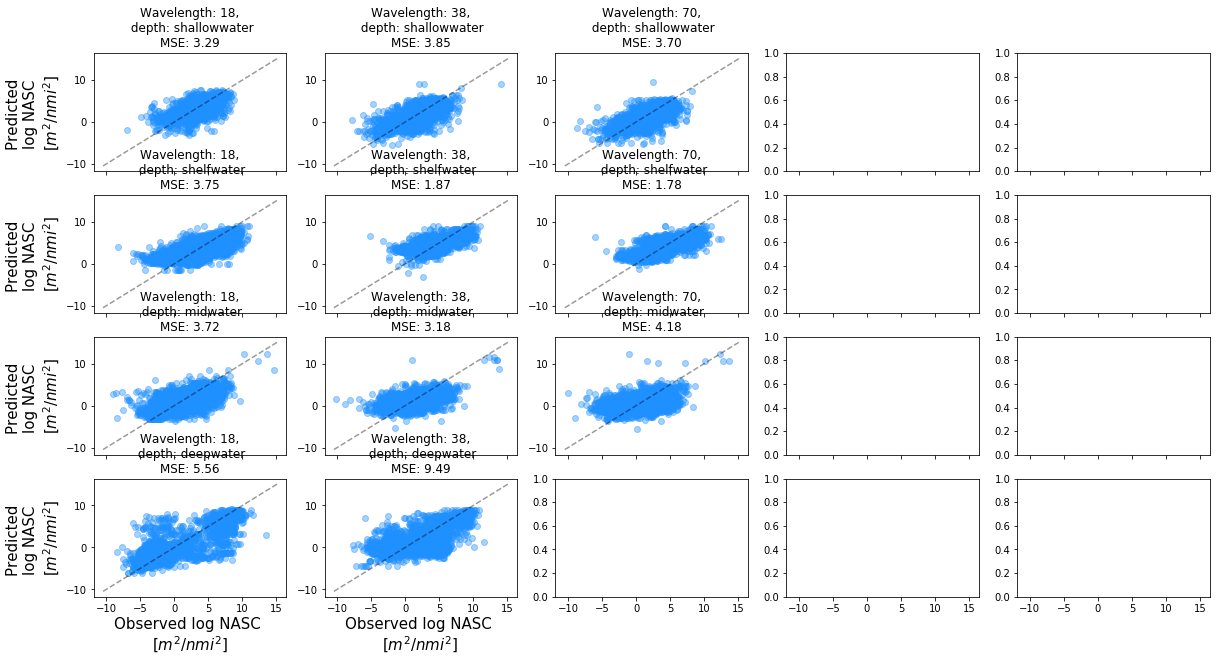

In [151]:
# Predicted vs. Obs log NASC: 2013 Raw Data

fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                           sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(drop_columns, axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)

        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)

        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))

        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)

plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: MSE Variable Importances - All Data - Quality Controlled Data\n',fontsize=20)
plt.savefig('2013_QC_alldata_RF-MSE_var_importances.png')
plt.show()


In [80]:
# 2013 File path and file exploration: Raw Data

path_2013 = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-07-09_2013_nasc_sonar.csv'

d = pd.read_csv(path_2013)#, nrows=10000) #had trouble getting permissions to read csv while trying to open in excel
print(d.columns)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
#d = d.query('log_nasc < 17.5')
d = d.query('log_nasc < 17.5 & is_raw == True')
#print(d)

#d = np.where(d['is_raw'] == True)
feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day',
    'is_raw'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
#print(d.head())
print(d.shape)
d = d.dropna()
print(type(d))
print(d.shape)


wavelengths = d.wavelength.unique()
wavelengths.sort()
depth_bins = d.depth_bin.unique()

print(wavelengths.shape)
print("wavelengths: ",wavelengths) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins)
print("file shape: ",d.shape)
#print("file shape with no NAN values: ",(d.dropna()).shape,'\n')
#print(d.columns)
#print(d.head())

Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=156)
(863299, 24)
<class 'pandas.core.frame.DataFrame'>
(219090, 24)
(5,)
wavelengths:  [ 18  38  70 120 200]
depth bins:  ['shallowwater' 'shelfwater' 'midwater' 'deepwater']
file shape:  (219090, 24)


In [97]:
# look at shape of each wavelength / depth_bin combo 

p = d.query("wavelength == 200 & depth_bin == 'deepwater'")
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins): 
        subd = d.query('wavelength == ' + str(wavelengths[i]))
        p = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        print(p.shape)

(7143, 24)
(21808, 24)
(18034, 24)
(12968, 24)
(7134, 24)
(21822, 24)
(18033, 24)
(12931, 24)
(7140, 24)
(21821, 24)
(18042, 24)
(0, 24)
(7145, 24)
(6405, 24)
(18051, 24)
(0, 24)
(7132, 24)
(0, 24)
(13481, 24)
(0, 24)


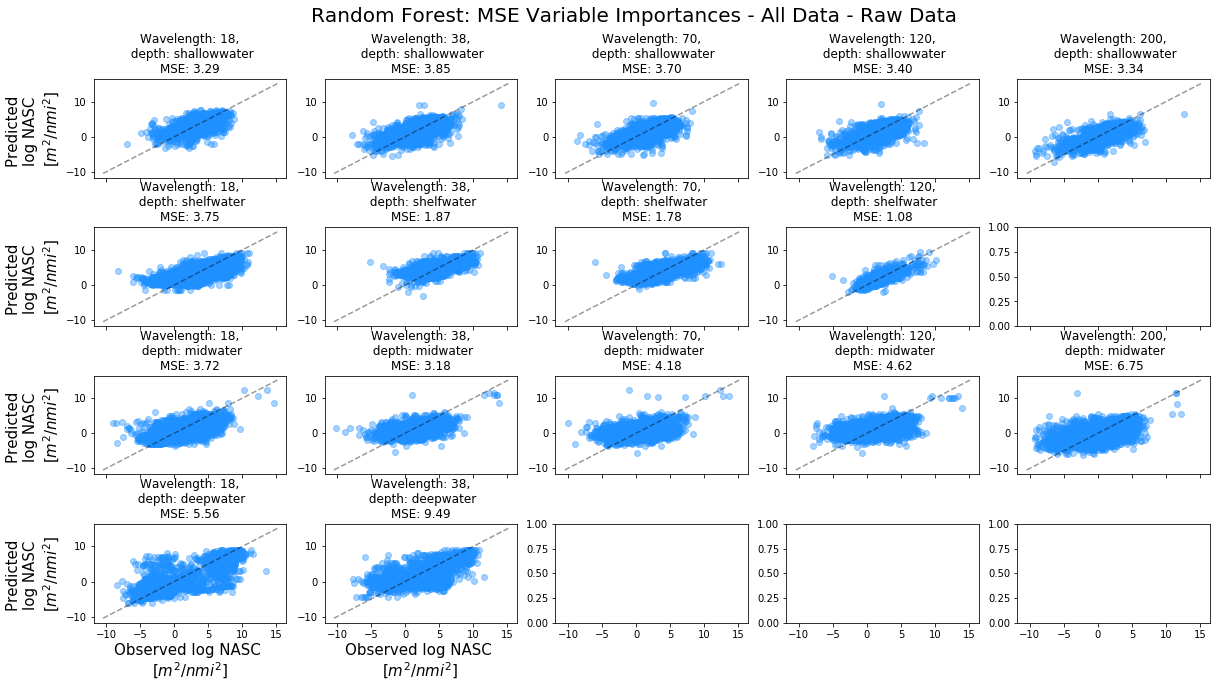

In [98]:
# Predicted vs. Obs log NASC: 2013 Quality Controlled Data

### Note: wavelengths 70,120,200 do not have any values at depth_bin 'deepwater'

fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                           sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        # check to see if x has has any rows, continue if no data
        if subd.shape == (0,24):
            continue
        
        x = subd.drop(drop_columns, axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)

        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)

        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))

        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)

plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: MSE Variable Importances - All Data - Raw Data\n',fontsize=20)
plt.savefig('2013_Raw_alldata_RF-MSE_var_importances.png')
plt.show()

In [43]:
# look at var type in each column of data csv

print(type(d))
print(d.dtypes)


<class 'pandas.core.frame.DataFrame'>
Day                            int64
wavelength                     int64
depth_bin                     object
is_raw                          bool
distance_from_shore_m        float64
depth_m                      float64
Lon                          float64
Lat                          float64
closest_chlor_a              float64
closest_nflh                 float64
closest_poc                  float64
closest_Rrs_412              float64
closest_Rrs_443              float64
closest_Rrs_469              float64
closest_Rrs_488              float64
closest_Rrs_531              float64
closest_Rrs_547              float64
closest_Rrs_555              float64
closest_Rrs_645              float64
closest_Rrs_667              float64
closest_Rrs_678              float64
closest_sst                  float64
closest_surface_elevation    float64
log_nasc                     float64
dtype: object
